<a href="https://colab.research.google.com/github/SauravMaheshkar/nanollm/blob/main/notebooks/nanollm_tiny_shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Configuration
BATCH_SIZE = 128  # @param {type:"integer"}
BLOCK_SIZE = 64  # @param {type:"integer"}
SEED = 42  # @param {type:"integer"}
NUM_EPOCHS = 1  # @param {type:"integer"}
LEARNING_RATE = 1e-3  # @param {type:"number"}
N_ITERATIONS = 10_000  # @param {type:"integer"}
N_FREQ_EVAL = 500  # @param {type:"integer"}
DROPOUT_RATE = 0.2  # @param {type:"number"}
NUM_LAYERS = 6  # @param {type:"integer"}
EMBED_SIZE = 256  # @param {type:"integer"}
NUM_HEADS = 8  # @param {type:"integer"}
HEAD_SIZE = 32  # @param {type:"integer"}

## 📦 Packages and Basic Setup
---

In [2]:
%%capture
!pip install --upgrade datasets

In [3]:
import datasets
import jax
import matplotlib.pyplot as plt
import optax
from flax import nnx
from rich.progress import track

In [4]:
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [5]:
from jax.experimental import mesh_utils
from jax.sharding import Mesh, NamedSharding
from jax.sharding import PartitionSpec as P

mesh = Mesh(mesh_utils.create_device_mesh((4, 2)), ("batch", "model"))

In [6]:
key = jax.random.PRNGKey(42)
dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))


@jax.jit
def get_batch(random_key, data):
    ix = jax.random.randint(
        random_key, shape=(BATCH_SIZE, 1), minval=0, maxval=len(data) - BLOCK_SIZE
    )
    x = dynamic_slice_vmap(data, ix, (BLOCK_SIZE,))
    y = dynamic_slice_vmap(data, ix + 1, (BLOCK_SIZE,))
    return x, y

## 💿 The Dataset
---

In [7]:
ds = datasets.load_dataset(
    "karpathy/tiny_shakespeare",
    split=["train", "test", "validation"],
    trust_remote_code=True,
)
train_ds, test_ds, val_ds = ds

## extract vocabulary and create mapping fns
train_text = train_ds[0]["text"]
vocab = sorted(set(train_text))

stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for i, ch in enumerate(vocab)}


def encode(s):
    return [stoi[c] for c in s]


def decode(l):  # noqa: E741
    return "".join([itos[i] for i in l])


train_ds = datasets.concatenate_datasets([train_ds, test_ds])


def encode_fn(example):
    return {"text": encode(example["text"])}


train_ds = train_ds.map(encode_fn)
val_ds = val_ds.map(encode_fn)

train_ds = train_ds.with_format("jax")
val_ds = val_ds.with_format("jax")

train_data = train_ds["text"][0]
val_data = val_ds["text"][0]

README.md:   0%|          | 0.00/6.10k [00:00<?, ?B/s]

tiny_shakespeare.py:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

## ✍️ Model Architecture
---

In [8]:
import jax
import jax.numpy as jnp


class MLP(nnx.Module):
    def __init__(
        self,
        rngs: nnx.Rngs,
        embed_size: int,
        dropout_rate: float,
    ) -> None:
        self.embed_size = embed_size
        self.dropout_rate = dropout_rate

        # ==== Layers ====
        self.input_linear = nnx.Linear(
            in_features=embed_size,
            out_features=4 * embed_size,
            kernel_init=nnx.with_partitioning(
                nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, "model"))
            ),
            bias_init=nnx.with_partitioning(
                nnx.initializers.zeros_init(), NamedSharding(mesh, P("model"))
            ),
            rngs=rngs,
        )
        self.output_linear = nnx.Linear(
            in_features=4 * embed_size,
            out_features=embed_size,
            kernel_init=nnx.with_partitioning(
                nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, "model"))
            ),
            bias_init=nnx.with_partitioning(
                nnx.initializers.zeros_init(), NamedSharding(mesh, P("model"))
            ),
            rngs=rngs,
        )
        self.dropout = nnx.Dropout(dropout_rate, rngs=rngs)

    def __call__(self, x):
        x = self.input_linear(x)
        x = nnx.relu(x)
        x = self.dropout(x)
        x = self.output_linear(x)
        return x


class TransformerBlock(nnx.Module):
    def __init__(
        self,
        rngs: nnx.Rngs,
        num_heads: int,
        head_size: int,
        dropout_rate: float,
        embed_size: int,
    ) -> None:
        self.num_heads = num_heads
        self.head_size = head_size
        self.dropout_rate = dropout_rate
        self.embed_size = embed_size

        # ==== Attention Layer ====
        self.attn = nnx.MultiHeadAttention(
            num_heads=self.num_heads,
            in_features=embed_size,
            qkv_features=embed_size,
            out_features=embed_size,
            dropout_rate=self.dropout_rate,
            kernel_init=nnx.with_partitioning(
                nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, "model"))
            ),
            bias_init=nnx.with_partitioning(
                nnx.initializers.zeros_init(), NamedSharding(mesh, P("model"))
            ),
            rngs=rngs,
        )

        # ==== Normalization Layers ====
        self.pre_norm = nnx.LayerNorm(
            num_features=embed_size,
            use_bias=False,
            scale_init=nnx.with_partitioning(
                nnx.initializers.ones_init(), NamedSharding(mesh, P(None, "model"))
            ),
            bias_init=nnx.with_partitioning(
                nnx.initializers.zeros_init(), NamedSharding(mesh, P(None, "model"))
            ),
            rngs=rngs,
        )
        self.post_norm = nnx.LayerNorm(
            num_features=embed_size,
            use_bias=False,
            scale_init=nnx.with_partitioning(
                nnx.initializers.ones_init(), NamedSharding(mesh, P(None, "model"))
            ),
            bias_init=nnx.with_partitioning(
                nnx.initializers.zeros_init(), NamedSharding(mesh, P(None, "model"))
            ),
            rngs=rngs,
        )

        # ==== MLP Layer ====
        self.mlp = MLP(
            rngs=rngs,
            embed_size=embed_size,
            dropout_rate=dropout_rate,
        )

    def __call__(self, x):
        batch_size, seq_len = x.shape[:2]

        # Create causal attention mask
        # Shape: (seq_len, seq_len)
        mask = jnp.tril(jnp.ones((seq_len, seq_len)))
        # Shape: (batch_size, num_heads, seq_len, seq_len)
        mask = jnp.expand_dims(mask, axis=(0, 1))
        mask = jnp.broadcast_to(mask, (batch_size, self.num_heads, seq_len, seq_len))

        x_norm = self.pre_norm(x)
        attn_outputs = self.attn(x_norm, x_norm, mask=mask, decode=False)
        x = x + attn_outputs

        x = self.post_norm(x)
        x = x + self.mlp(x)

        return x


class NanoLLM(nnx.Module):
    def __init__(
        self,
        rngs: nnx.Rngs,
        vocab_size: int,
        num_layers: int = 6,
        num_heads: int = 8,
        head_size: int = 32,
        dropout_rate: float = 0.2,
        embed_size: int = 256,
        block_size: int = 64,
    ) -> None:
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.head_size = head_size
        self.dropout_rate = dropout_rate
        self.embed_size = embed_size
        self.block_size = block_size

        # ==== Embedding Layers ====
        self.token_emb = nnx.Embed(
            num_embeddings=self.vocab_size, features=self.embed_size, rngs=rngs
        )
        self.pos_emb = nnx.Embed(
            num_embeddings=self.block_size, features=self.embed_size, rngs=rngs
        )

        # ==== Transformer Blocks ====
        self.blocks = [
            TransformerBlock(
                rngs=rngs,
                num_heads=self.num_heads,
                head_size=self.head_size,
                dropout_rate=self.dropout_rate,
                embed_size=self.embed_size,
            )
            for _ in range(self.num_layers)
        ]

        # ==== Output Layer ====
        self.output_layer = nnx.Linear(
            in_features=self.embed_size,
            out_features=self.vocab_size,
            kernel_init=nnx.with_partitioning(
                nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, "model"))
            ),
            bias_init=nnx.with_partitioning(
                nnx.initializers.zeros_init(), NamedSharding(mesh, P("model"))
            ),
            rngs=rngs,
        )

    def __call__(self, x):
        seq_len = x.shape[1]
        positions = jnp.arange(seq_len)

        # ==== Embeddings ====
        position_emb = self.pos_emb(positions)
        token_emb = self.token_emb(x)
        x = token_emb + position_emb

        # ==== Transformer Blocks ====
        for block in self.blocks:
            x = block(x)

        # ==== Output Layer ====
        return self.output_layer(x)

    @property
    def state(self) -> nnx.State:
        """Splits state from the graph and returns it"""
        return nnx.split(self, nnx.Param, ...)[1]

    @property
    def num_params(self) -> int:
        return sum(p.size for p in jax.tree.leaves(self.state))


## 🏃 Train !!
---

In [9]:
def loss_fn(model, batch):
    logits = model(batch[0])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch[1]
    ).mean()
    return loss, logits


@nnx.jit
def train_step(
    model: nnx.Module, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch
):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, lables=batch[1])
    optimizer.update(grads)

In [10]:
model = NanoLLM(
    vocab_size=len(vocab),
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    head_size=HEAD_SIZE,
    dropout_rate=DROPOUT_RATE,
    embed_size=EMBED_SIZE,
    block_size=BLOCK_SIZE,
    rngs=nnx.Rngs(0),
)

print(f"Total number of parameters: {model.num_params:_}")

optimizer = nnx.Optimizer(model, optax.adamw(LEARNING_RATE, nesterov=True))
metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average("loss"),
)
rng = jax.random.PRNGKey(0)
metrics_history = {
    "train_loss": [],
}

Total number of parameters: 4_785_217


In [11]:
model.train()
for epoch in range(NUM_EPOCHS):
    for i in track(range(N_ITERATIONS)):
        rng, subkey = jax.random.split(rng)
        batch = get_batch(subkey, train_data)
        train_step(
            model,
            optimizer,
            metrics,
            jax.device_put((batch), NamedSharding(mesh, P("batch", None))),
        )

        if i % N_FREQ_EVAL == 0:
            for metric, value in metrics.compute().items():
                metrics_history[f"train_{metric}"].append(value)
            metrics.reset()
            print(f"Iteration {i}, Loss: {metrics_history['train_loss'][-1]:.4f}")

Output()

Iteration 0, Loss: 4.9320

Iteration 500, Loss: 2.9968

Iteration 1000, Loss: 2.0426

Iteration 1500, Loss: 1.6648

Iteration 2000, Loss: 1.5290

Iteration 2500, Loss: 1.4604

Iteration 3000, Loss: 1.4139

Iteration 3500, Loss: 1.3802

Iteration 4000, Loss: 1.3541

Iteration 4500, Loss: 1.3319

Iteration 5000, Loss: 1.3145

Iteration 5500, Loss: 1.2983

Iteration 6000, Loss: 1.2830

Iteration 6500, Loss: 1.2699

Iteration 7000, Loss: 1.2569

Iteration 7500, Loss: 1.2461

Iteration 8000, Loss: 1.2334

Iteration 8500, Loss: 1.2241

Iteration 9000, Loss: 1.2125

Iteration 9500, Loss: 1.2054

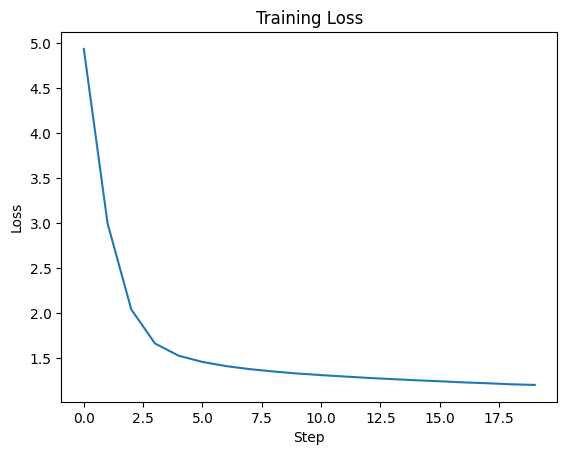

In [12]:
plt.plot(metrics_history["train_loss"])
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()